# Importing inportant Libraries

In [2]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

# DATA PROCESSING

In [3]:
sentiment_df = pd.read_csv("fear_greed_index.csv")
trader_df = pd.read_csv("historical_data.csv")

In [4]:
# Convert 'date' in sentiment to datetime
sentiment_df['date'] = pd.to_datetime(sentiment_df['date'])

# Convert 'Timestamp IST' in trader data to datetime
trader_df['date'] = pd.to_datetime(trader_df['Timestamp IST'], format='%d-%m-%Y %H:%M', errors='coerce')

# Drop rows with invalid dates
trader_df = trader_df.dropna(subset=['date'])

# Aggregate trader performance by day
daily_perf = trader_df.groupby(trader_df['date'].dt.date).agg({
    'Closed PnL': 'sum',
    'Trade ID': 'count'
}).rename(columns={'Closed PnL': 'Daily_PnL', 'Trade ID': 'Trade_Count'}).reset_index()

# Prepare sentiment date for merging
sentiment_df['date_only'] = sentiment_df['date'].dt.date

# Merge sentiment with daily trader performance
merged_df = pd.merge(daily_perf, sentiment_df, left_on='date', right_on='date_only', how='inner')

In [5]:
merged_df

,date_x,Daily_PnL,Trade_Count,timestamp,value,classification,date_y,date_only
0,2023-05-01,0.000000,3,1682919000,63,Greed,2023-05-01,2023-05-01
1,2023-12-05,0.000000,9,1701754200,75,Extreme Greed,2023-12-05,2023-12-05
2,2023-12-14,-205.434737,11,1702531800,72,Greed,2023-12-14,2023-12-14
3,2023-12-15,-24.632034,2,1702618200,70,Greed,2023-12-15,2023-12-15
4,2023-12-16,0.000000,3,1702704600,67,Greed,2023-12-16,2023-12-16
...,...,...,...,...,...,...,...,...
474,2025-04-27,2702.067468,337,1745731800,61,Greed,2025-04-27,2025-04-27
475,2025-04-28,36906.813759,1379,1745818200,54,Neutral,2025-04-28,2025-04-28
476,2025-04-29,125749.613427,2243,1745904600,60,Greed,2025-04-29,2025-04-29
477,2025-04-30,14003.797269,1113,1745991000,56,Greed,2025-04-30,2025-04-30


# Feature engineering

In [6]:
# Encode sentiment as binary: Fear = 0, Greed = 1
merged_df['Sentiment_Binary'] = merged_df['classification'].apply(
    lambda x: 1 if 'Greed' in x else 0
)

#  Normalize 'value' column (sentiment score) if needed
merged_df['Sentiment_Score'] = merged_df['value'] / 100.0

# Profit per trade
merged_df['PnL_per_Trade'] = merged_df['Daily_PnL'] / merged_df['Trade_Count']

merged_df['Profitable'] = (merged_df['Daily_PnL'] > 0).astype(int)

In [7]:
merged_df

,date_x,Daily_PnL,Trade_Count,timestamp,value,classification,date_y,date_only,Sentiment_Binary,Sentiment_Score,PnL_per_Trade,Profitable
0,2023-05-01,0.000000,3,1682919000,63,Greed,2023-05-01,2023-05-01,1,0.63,0.000000,0
1,2023-12-05,0.000000,9,1701754200,75,Extreme Greed,2023-12-05,2023-12-05,1,0.75,0.000000,0
2,2023-12-14,-205.434737,11,1702531800,72,Greed,2023-12-14,2023-12-14,1,0.72,-18.675885,0
3,2023-12-15,-24.632034,2,1702618200,70,Greed,2023-12-15,2023-12-15,1,0.70,-12.316017,0
4,2023-12-16,0.000000,3,1702704600,67,Greed,2023-12-16,2023-12-16,1,0.67,0.000000,0
...,...,...,...,...,...,...,...,...,...,...,...,...
474,2025-04-27,2702.067468,337,1745731800,61,Greed,2025-04-27,2025-04-27,1,0.61,8.018004,1
475,2025-04-28,36906.813759,1379,1745818200,54,Neutral,2025-04-28,2025-04-28,0,0.54,26.763462,1
476,2025-04-29,125749.613427,2243,1745904600,60,Greed,2025-04-29,2025-04-29,1,0.60,56.063136,1
477,2025-04-30,14003.797269,1113,1745991000,56,Greed,2025-04-30,2025-04-30,1,0.56,12.582028,1


# Exploratory Data Analysis

1. Sentiment vs Daily

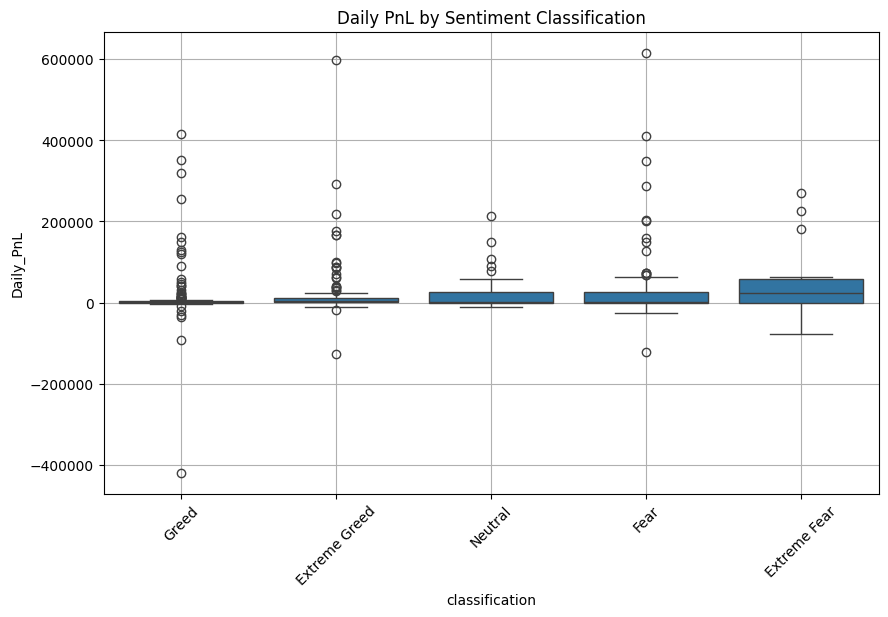

In [8]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=merged_df, x='classification', y='Daily_PnL')
plt.title('Daily PnL by Sentiment Classification')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


2. Sentiment Score vs PnL per Trade (Scatter)

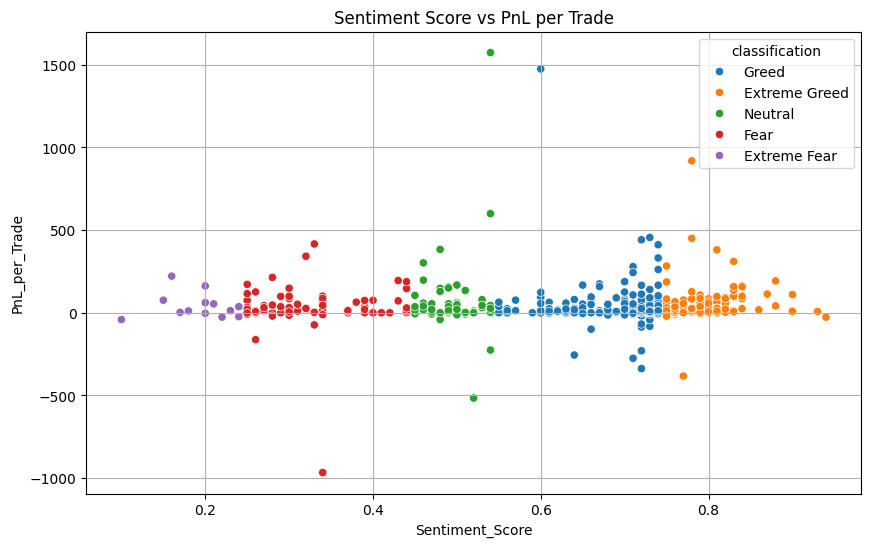

In [9]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=merged_df, x='Sentiment_Score', y='PnL_per_Trade', hue='classification')
plt.title('Sentiment Score vs PnL per Trade')
plt.grid(True)
plt.show()

Correlation Matrix

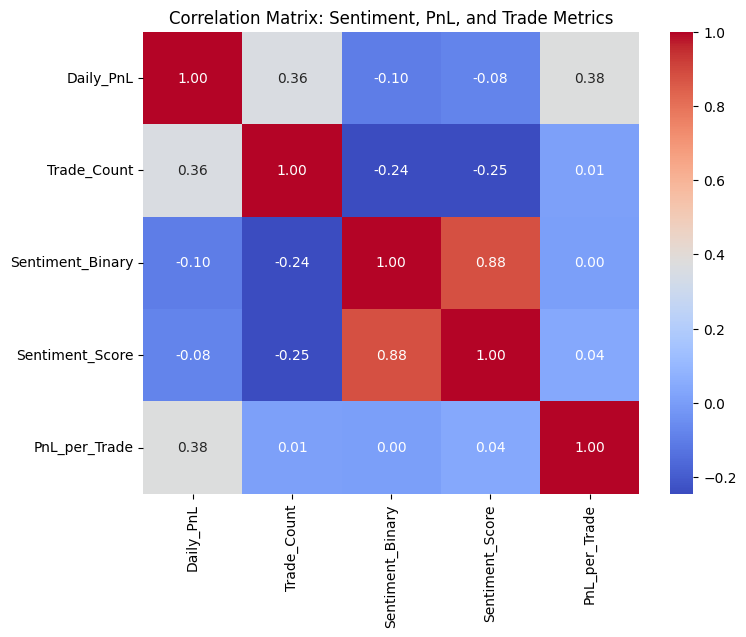

In [11]:
corr_features = merged_df[['Daily_PnL', 'Trade_Count', 'Sentiment_Binary', 'Sentiment_Score', 'PnL_per_Trade']]

corr_matrix = corr_features.corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix: Sentiment, PnL, and Trade Metrics")
plt.show()

Sentiment-Based Trade Volume Analysis

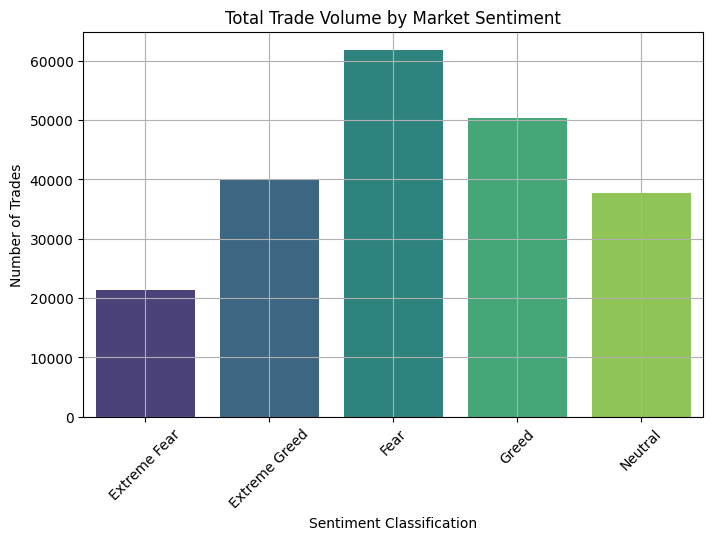

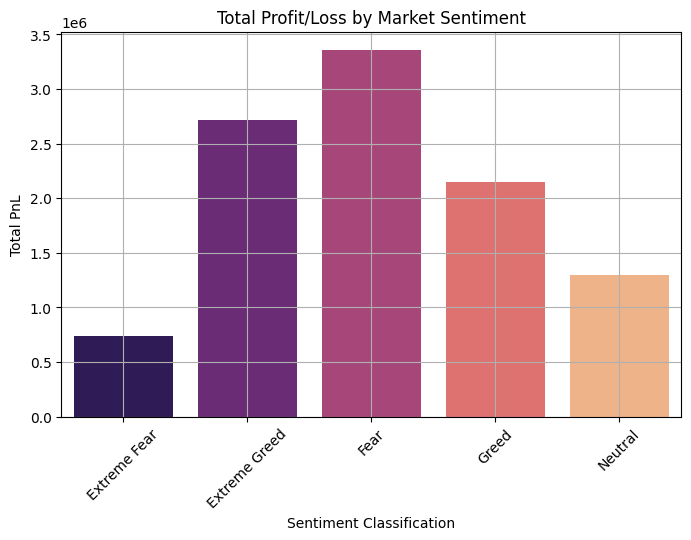

In [12]:
# Aggregate trade volume by sentiment
volume_by_sentiment = merged_df.groupby('classification').agg({
    'Trade_Count': 'sum',
    'Daily_PnL': 'sum'
}).reset_index()

# Plot trade count
plt.figure(figsize=(8, 5))
sns.barplot(data=volume_by_sentiment, x='classification', y='Trade_Count', palette='viridis')
plt.title('Total Trade Volume by Market Sentiment')
plt.ylabel('Number of Trades')
plt.xlabel('Sentiment Classification')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

print()

# Plot total PnL
plt.figure(figsize=(8, 5))
sns.barplot(data=volume_by_sentiment, x='classification', y='Daily_PnL', palette='magma')
plt.title('Total Profit/Loss by Market Sentiment')
plt.ylabel('Total PnL')
plt.xlabel('Sentiment Classification')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


# Insights

In [13]:
# Analyze mean performance by sentiment classification
insights = merged_df.groupby('classification').agg({
    'Daily_PnL': ['mean', 'std'],
    'Trade_Count': 'mean',
    'Profitable': 'mean'
}).round(2)

# Rename columns for clarity
insights.columns = ['Mean_PnL', 'PnL_StdDev', 'Avg_Trade_Count', 'Profitability_Rate']
insights.reset_index(inplace=True)

# Sort by profitability rate
insights.sort_values(by='Profitability_Rate', ascending=False)

,classification,Mean_PnL,PnL_StdDev,Avg_Trade_Count,Profitability_Rate
1,Extreme Greed,23817.29,72827.30,350.81,0.88
2,Fear,36891.82,96611.85,679.53,0.74
3,Greed,11140.57,62427.96,260.64,0.73
4,Neutral,19297.32,37995.21,562.48,0.67
0,Extreme Fear,52793.59,101262.39,1528.57,0.64
